In [39]:
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import TimeLimit
import matplotlib.pyplot as plt
from tqdm import tqdm

In [76]:
env = TimeLimit(gym.make('CliffWalking-v0'), max_episode_steps=60)
train_seed = 42
test_seed = 44

In [57]:
observation, _ = env.reset(seed=test_seed)
observation

36

In [58]:
def play_policy(env, policy=None):
    observation, _ = env.reset()
    episode_reward, elapsed_steps = 0, 0

    while True:
        if policy is None:
            action = env.action_space.sample()
        else:
            action = np.random.choice(env.action_space.n, p=policy[observation])

        observation, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if terminated or truncated:
            break
    return episode_reward, elapsed_steps

In [59]:
def test_policy(n, env, policy, test_seed):
    env.reset(seed=test_seed)
    rewards = [play_policy(env, policy)[0] for _ in range(n)]
    return np.mean(rewards), np.std(rewards)

In [60]:
env.unwrapped.__dict__

{'shape': (4, 12),
 'start_state_index': np.int64(36),
 'nS': np.int64(48),
 'nA': 4,
 'is_slippery': False,
 '_cliff': array([[False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True, False]]),
 'P': {0: {0: [(1.0, np.int64(0), -1, False)],
   1: [(1.0, np.int64(1), -1, False)],
   2: [(1.0, np.int64(12), -1, False)],
   3: [(1.0, np.int64(0), -1, False)]},
  1: {0: [(1.0, np.int64(1), -1, False)],
   1: [(1.0, np.int64(2), -1, False)],
   2: [(1.0, np.int64(13), -1, False)],
   3: [(1.0, np.int64(0), -1, False)]},
  2: {0: [(1.0, np.int64(2), -1, False)],
   1: [(1.0, np.int64(3), -1, False)],
   2: [(1.0, np.int64(14), -1, False)],
   3: [(1.0, np.int

In [ ]:
def display(data):
    figure = plt.figure()


In [72]:
def mc_exploring_start(env, train_seed, no_episodes=500000, gamma=1):
    env.reset(seed=train_seed)

    no_states = env.env.env.observation_space.n
    no_actions = env.env.env.action_space.n

    policy = np.ones((no_states, no_actions)) / no_actions
    #policy[:, 0] = 1 # Only move up.
    q = np.zeros(policy.shape)
    c = np.zeros(policy.shape)

    for _ in tqdm(range(no_episodes)):
        # Choose initial state randomly. Ensure it is not on an invalid position
        state = np.random.randint(37)
        action = np.random.randint(4)

        env.reset()
        env.unwrapped.s = state

        state_actions = []
        rewards = []
        while True:
            state_actions.append((state, action))
            state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
            if terminated or truncated:
                break
            action = np.random.choice(no_actions, p=policy[state])

        g = 0
        for (state, action), reward in zip(reversed(state_actions), reversed(rewards)):
            g = gamma * g + reward
            c[state, action] += 1
            q[state, action] += (g - q[state, action]) / c[state, action]

            a = q[state].argmax()
            #policy[state] = softmax(q[state])
            policy[state] = 0
            policy[state, a] = 1
    return policy, q

In [73]:
directions = ["↑", "→", "↓", "←"]

In [77]:
policy, q = mc_exploring_start(env, train_seed, no_episodes=600000, gamma=1)

100%|██████████| 600000/600000 [01:13<00:00, 8151.86it/s]


In [78]:
[[directions[x] for x in lst] for lst in policy.argmax(axis=1).reshape(4, -1).tolist()]

[['→', '↓', '→', '↓', '→', '↓', '↓', '→', '→', '→', '↓', '↓'],
 ['↓', '↓', '→', '↓', '→', '→', '→', '→', '→', '→', '→', '↓'],
 ['→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '↓'],
 ['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑']]

In [79]:
test_policy(200, env, policy, test_seed)

(np.float64(-13.0), np.float64(0.0))

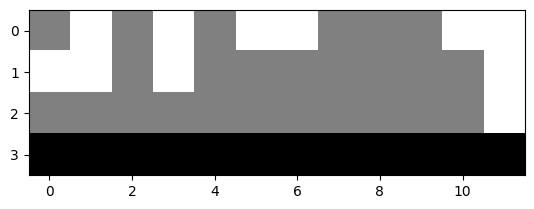

In [86]:
plt.imshow(q.argmax(axis=1).reshape(4,-1), cmap='gray')

In [104]:
def mc_soft_policy(env, train_seed, no_episodes=500000, gamma=1, epsilon=0.1, epsilon_decay=1e-5):
    env.reset(seed=train_seed)
    no_states = env.env.env.observation_space.n
    no_actions = env.env.env.action_space.n
    policy = np.ones((no_states, no_actions)) / no_actions
    q = np.zeros(policy.shape)
    c = np.zeros(policy.shape)
    for _ in tqdm(range(no_episodes)):
        state_actions = []
        rewards = []
        state, _ = env.reset()
        while True:
            action = np.random.choice(no_actions, p=policy[state])
            state_actions.append((state, action))
            state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
            if terminated or truncated:
                break

        g = 0
        for (state, action), reward in zip(reversed(state_actions), reversed(rewards)):
            g = gamma * g + reward
            c[state, action] += 1
            q[state, action] += (g - q[state, action]) / c[state, action]

            # soft update
            a = q[state].argmax()
            policy[state] = epsilon / no_actions
            policy[state, a] += (1 - epsilon)
        epsilon = max(epsilon - epsilon_decay, 0.1)
    return policy, q

In [117]:
def mc_soft_policy(env, train_seed, no_episodes=500000, gamma=1, epsilon=0.1, epsilon_decay=1e-5):
    env.reset(seed=train_seed)
    no_states = env.env.env.observation_space.n
    no_actions = env.env.env.action_space.n
    policy = np.ones((no_states, no_actions)) / no_actions
    q = np.zeros(policy.shape)
    c = np.zeros(policy.shape)

    for _ in tqdm(range(no_episodes)):
        state_actions = []
        rewards = []
        state, _ = env.reset()
        # Generate an episode
        while True:
            action = np.random.choice(no_actions, p=policy[state])
            state_actions.append((state, action))
            state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
            if terminated or truncated:
                break

        # Calculate returns and update Q-values
        g = 0
        # Track visited states for policy update
        visited_states = set()
        for i in reversed(range(len(rewards))):
            state, action = state_actions[i]
            g = gamma * g + rewards[i]
            c[state, action] += 1
            q[state, action] += (g - q[state, action]) / c[state, action]
            visited_states.add(state)  # Mark state for policy update

        # Update policy for all states visited in this episode
        for state in visited_states:
            best_action = np.argmax(q[state])
            policy[state] = epsilon / no_actions
            policy[state, best_action] += 1 - epsilon  # Ensure probabilities sum to 1

        # Decay epsilon
        epsilon = max(epsilon - epsilon_decay, 0.1)

    return policy, q

In [119]:
def mc_soft_policy(env, train_seed, no_episodes=500000, gamma=1.0, epsilon=1.0, epsilon_min=0.1, epsilon_decay=1e-6):
    # Set seed for reproducibility
    env.reset(seed=train_seed)

    no_states = env.observation_space.n
    no_actions = env.action_space.n

    # Initialize policy and Q-table
    policy = np.ones((no_states, no_actions)) / no_actions
    q = -1 * np.ones((no_states, no_actions))  # Optimistic initialization
    c = np.zeros((no_states, no_actions))      # Visit counts for averaging

    for _ in tqdm(range(no_episodes)):
        state, _ = env.reset()
        episode = []
        done = False

        # Generate one episode
        while not done:
            action = np.random.choice(no_actions, p=policy[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated

        # Calculate returns and first-visit updates
        g = 0
        visited = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            g = gamma * g + reward

            if (state, action) not in visited:
                visited.add((state, action))
                c[state, action] += 1
                q[state, action] += (g - q[state, action]) / c[state, action]

                # Soft policy improvement
                best_action = np.argmax(q[state])
                policy[state] = epsilon / no_actions
                policy[state, best_action] += (1.0 - epsilon)

        # Decay epsilon
        epsilon = max(epsilon - epsilon_decay, epsilon_min)

    return policy, q

In [120]:
# I tried really hard to make this soft policy algorithm work, but it seems that it cannot effectively solve the cliffwalking environment.
env = gym.make('CliffWalking-v0')
policy_soft, q_soft = mc_soft_policy(env, train_seed)

  1%|          | 5713/500000 [06:27<9:18:06, 14.76it/s] 


KeyboardInterrupt: 

In [115]:
[[directions[x] for x in lst] for lst in policy_soft.argmax(axis=1).reshape(4, -1).tolist()]

[['↑', '→', '→', '↑', '→', '→', '→', '→', '→', '→', '→', '↓'],
 ['→', '→', '→', '→', '→', '→', '↑', '→', '→', '→', '→', '↓'],
 ['←', '↑', '↓', '↑', '←', '↑', '→', '↑', '↑', '↑', '→', '↓'],
 ['←', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑']]

In [112]:
test_policy(200, env, policy_soft, test_seed)

(np.float64(-227.78), np.float64(236.61111892723892))

In [143]:
def mc_importance_sampling(env, train_seed, gamma=1, no_episodes=500000):
    state, _ = env.reset(seed=train_seed)
    no_states = int(env.env.env.observation_space.n)
    no_actions = int(env.env.env.action_space.n)

    policy = np.zeros((no_states, no_actions))
    policy[:, 0] = 1 # only go up.
    behaviour_policy = np.ones(policy.shape) / no_actions

    q = np.zeros(policy.shape)
    c = np.zeros(policy.shape)
    for _ in tqdm(range(no_episodes)):
        state_actions = []
        rewards = []
        state, _ = env.reset()
        done = False
        while not done:
            action = np.random.choice(no_actions, p=behaviour_policy[state])
            state_actions.append((state, action))
            state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
            done = terminated or truncated

        g = 0
        rho = 1
        for (state, action), reward in zip(reversed(state_actions), reversed(rewards)):
            g = gamma * g + reward
            c[state, action] += rho
            q[state, action] += rho / c[state, action] * (g - q[state, action])

            a = q[state].argmax()
            policy[state] = 0
            policy[state, a] = 1
            if a != action: break # early stop.
            rho /= behaviour_policy[state, action]
    return policy, q

In [146]:
env = TimeLimit(gym.make('CliffWalking-v0'), max_episode_steps=60)
policy_imp, q_imp = mc_importance_sampling(env, train_seed)

100%|██████████| 500000/500000 [05:30<00:00, 1514.02it/s]


In [147]:
policy_imp.argmax(axis=1).reshape(4,-1)

array([[0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 0, 1],
       [0, 3, 0, 1, 1, 1, 1, 1, 0, 2, 0, 2],
       [1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [148]:
test_policy(200, env, policy_imp, test_seed)

(np.float64(-60.0), np.float64(0.0))